In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as d
import matplotlib.pyplot as plt
import json
import sklearn

In [2]:
#Parameters
time_length = 60; #seconds
sampletot = 20000
samplenum = 15000
testsize = 1-samplenum/sampletot
epochs = 150
minibatch_size= 1000
hiddenlayers = [140]
input_size = 3
output_size = 3*time_length
learning_rate = 0.01
LRdecay = 0.4

In [9]:
#Load Samples

with open('Data/Samples/data_20k.json') as json_file:
    data = json.load(json_file)
    p = np.zeros((3*time_length, data['Description'][0]['samplenum']))
    y_target = np.zeros((data['Description'][0]['samplenum'], 3))
    for i, p_i in enumerate(data['parameter']):
        p[:, i] = np.array(p_i)
    for s, y_s in enumerate(data['y_target']):
        y_target[s, :] = np.array(y_s)
        y_target[s, 1] = y_target[s, 1]-1 #min-max scaling
p = p.transpose()

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
y_train, y_test, p_train, p_test = train_test_split(y_target, p, test_size = testsize)

y_target = torch.tensor(y_train).float()
p = torch.tensor(p_train).float()
y_test = torch.tensor(y_test).float()
p_test = torch.tensor(p_test).float()

#print(y_target.shape)
#print(p.shape)
#print(y_test.shape)
#print(p_test.shape)

## Building the custon Simulation activation function and model

In [10]:
class ActiveLearn(nn.Module):

    def __init__(self, n_in, out_sz):
        super(ActiveLearn, self).__init__()

        self.L_in = nn.Linear(n_in, hiddenlayers[0])
        self.H1 = nn.Linear(hiddenlayers[0], 3*time_length)
        #self.H2 = nn.Linear(hiddenlayers[1], 3*time_length)
        #self.H3 = nn.Linear(hiddenlayers[2], 3*time_length)
        self.L_out = nn.Linear(3*time_length, 3*time_length)
        self.Relu = nn.ReLU(inplace=True)
    
    def forward(self, input):
        x = self.L_in(input)
        x = self.Relu(x)
        x = self.H1(x)
        #x = self.Relu(x)
        #x = self.H2(x)
        x = self.Relu(x)
        x = self.L_out(x)
        return x


model = ActiveLearn(input_size, output_size)

criterion = nn.MSELoss()  # RMSE = np.sqrt(MSE)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma=LRdecay, last_epoch=-1)

## Train the model

In [11]:
torch.autograd.set_detect_anomaly(True)

start_time = time.time()
weight_c1 = 1 # p error condition
weight_c2 = 1 # p start condition
weight_c3 = 0.3 # p smoothness condition
batch = np.floor(samplenum/minibatch_size).astype(int)
losses= []
p_smoothness_errors = []
basic_errors = [] #y_end_ and p_start error
for e in range(epochs):
    for b in range(batch):
        loss_batch = 0
        smoothness_error_batch = 0
        y_i = y_target[b*minibatch_size:b*minibatch_size+minibatch_size,:]
        p_i = p[b*minibatch_size:b*minibatch_size+minibatch_size,:]
        p_pred = model(y_i)

        #error claculation
        p_error = weight_c1* criterion(p_pred, p_i)
        p_start_error = weight_c2*torch.sqrt(criterion(p_pred[0:3], p_i[0:3]))
        p_smoothness_error = weight_c3*torch.sqrt(criterion(p_pred[:, 0:3*(time_length-1)], p_pred[:, 3:3*time_length]))
        loss = p_error + p_start_error + p_smoothness_error
        losses.append(loss)
        p_smoothness_errors.append(p_smoothness_error)
        basic_error = loss - p_smoothness_error
        basic_errors.append(basic_error)
        optimizer.zero_grad()
        #Back Prop
        loss.backward()
        optimizer.step()
    scheduler.step()
    LR= scheduler.get_lr()
    if e%10 == 0:
        print(f'epoch: {e:3}/{epochs}    LR: {LR[0]:10.6f}    smoothness error: {p_smoothness_error.item():10.4f}   basic error: {basic_error.item():10.4f}')
    

print(f'epoch: {e:3} loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed

epoch:   0/150    LR:   0.010000    smoothness error:     0.0505   basic error:     0.4514
epoch:  10/150    LR:   0.004000    smoothness error:     0.0050   basic error:     0.0365
epoch:  20/150    LR:   0.001600    smoothness error:     0.0033   basic error:     0.0153
epoch:  30/150    LR:   0.000640    smoothness error:     0.0031   basic error:     0.0134
epoch:  40/150    LR:   0.000256    smoothness error:     0.0029   basic error:     0.0048
epoch:  50/150    LR:   0.000102    smoothness error:     0.0029   basic error:     0.0044
epoch:  60/150    LR:   0.000041    smoothness error:     0.0028   basic error:     0.0046
epoch:  70/150    LR:   0.000016    smoothness error:     0.0028   basic error:     0.0035
epoch:  80/150    LR:   0.000007    smoothness error:     0.0028   basic error:     0.0035
epoch:  90/150    LR:   0.000003    smoothness error:     0.0028   basic error:     0.0034
epoch: 100/150    LR:   0.000001    smoothness error:     0.0028   basic error:     0.0034

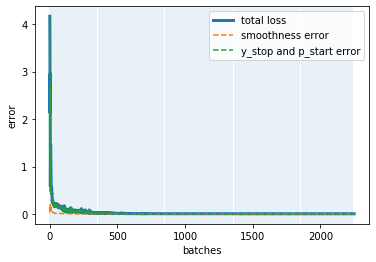

In [6]:
#plot errors after each epoch
epoch_lines = np.arange(0, epochs*batch, batch)
loss = plt.plot(losses, label = 'total loss', linewidth=3)
smoothness = plt.plot(p_smoothness_errors, label = 'smoothness error', linestyle='--')
basic = plt.plot(basic_errors, label = 'y_stop and p_start error', linestyle='--')
plt.legend()
plt.ylabel('error')
plt.xlabel('batches')
for xc in epoch_lines:
    plt.axvline(x=xc, linewidth = 0.2)
plt.show()

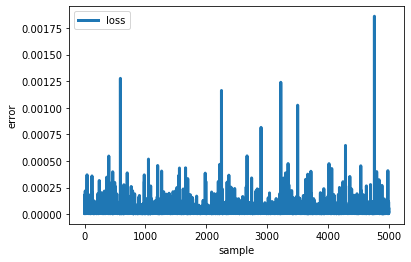

In [12]:
#Test the data
losses_test= []
with torch.no_grad():
    for i in range(sampletot-samplenum):
        p_val = model(y_test[i, :])
        loss2 = criterion(p_val,p_test[i,:])
        losses_test.append(loss2.clone().numpy())
#plot test errors
loss2 = plt.plot(losses_test, label = 'loss', linewidth=3)
plt.legend()
plt.ylabel('error')
plt.xlabel('sample')
plt.show()

In [8]:
#Save Model
torch.save(model.state_dict(), 'Trained_Models/Trained_Model_160620_15000s_200e_60t.pt')

## Test forward propagation

In [ ]:
y_target_test= torch.tensor([0, 2, 0.5])
p = model(y_target_test)
y_pred = Simulate(p)
y_target = y_target_test.detach().numpy()
p = p.detach().numpy()


yTraj_test = dyn.compute(p)

print(yTraj_test.y)
print(np.sum(yTraj_test.y[-3:]-y_target))
print(p)

## Torch Script Conversion and Saving

In [9]:
input_example = torch.tensor([0, 2, 0.5])
traced_script_module = torch.jit.trace(model, input_example)

# Test the torch script
test_input = torch.tensor([0, 2, 0.5])
original = model(test_input)
output_example = traced_script_module(test_input)
print(output_example[-12:])
print(original)

tensor([0.0085, 2.9835, 0.3418, 0.0092, 2.9882, 0.3455, 0.0055, 2.9873, 0.3418,
        0.0086, 2.9811, 0.3453], grad_fn=<SliceBackward>)
tensor([2.5808e-03, 3.0081e+00, 3.1791e-03, 1.1974e-03, 3.0075e+00, 1.4736e-02,
        6.0020e-04, 3.0065e+00, 2.7512e-02, 5.5888e-03, 3.0078e+00, 3.5061e-02,
        5.8926e-03, 3.0036e+00, 4.4258e-02, 3.0921e-03, 3.0035e+00, 5.8367e-02,
        5.6391e-03, 3.0029e+00, 6.9328e-02, 6.5393e-03, 3.0008e+00, 8.0125e-02,
        6.2950e-03, 3.0021e+00, 9.0980e-02, 9.8548e-03, 2.9971e+00, 1.0162e-01,
        8.3835e-03, 2.9970e+00, 1.1152e-01, 1.3283e-02, 2.9970e+00, 1.2224e-01,
        1.2102e-02, 2.9956e+00, 1.3562e-01, 1.1550e-02, 2.9926e+00, 1.4257e-01,
        1.3270e-02, 2.9921e+00, 1.4972e-01, 1.3638e-02, 2.9884e+00, 1.6055e-01,
        1.4162e-02, 2.9903e+00, 1.7243e-01, 1.6809e-02, 2.9887e+00, 1.8213e-01,
        1.4048e-02, 2.9845e+00, 1.8768e-01, 1.2780e-02, 2.9853e+00, 1.9705e-01,
        1.5460e-02, 2.9836e+00, 2.0611e-01, 1.5653e-02, 2.9851

In [11]:
# Save serialized model
traced_script_module.save("Serialized_Models/CPP_example_model_omni_latest.pt")